<a href="https://colab.research.google.com/github/sriharsha-sreenatha/CSCI596_FinalProject/blob/Grad-CAM-predict/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Grad CAM and use-cases**

Import required packages

In [23]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from skimage import io
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
tf.config.run_functions_eagerly(True)

Load VGG model and load image of a lion

In [ ]:
model = VGG16(weights="imagenet")


553476096/553467096 [==============================] - 6s 0us/step


Load and pre-process image of a lion

In [ ]:
lion = io.imread("https://conservationaction.co.za/wp-content/uploads/2018/08/CHAS1066.jpg")
lion = cv2.resize(lion, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(lion)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


Get predictions from the model for the lion image

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


49152/35363 [=========================================] - 0s 0us/step
Predicted label: lion


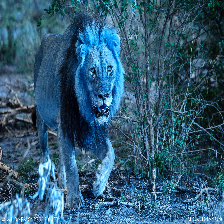

In [ ]:
preds = model.predict(x)
label = decode_predictions(preds, top=1)
class_idx = np.argmax(preds[0])
#print(class_idx)
print(f"Predicted label: {label[0][0][1]}")
class_output = model.output[:, class_idx]
cv2_imshow(lion)

Visualize last layer of model using Grad-CAM


In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Generate heatmap of where exactly the model is looking at - in the final layer

In [ ]:
# Get the heatmap
heatmap = make_gradcam_heatmap(x, model, "block5_conv2")

# Convert into JET COLORMAP (red-blue-green)
heatmap = cv2.resize(heatmap, (lion.shape[1], lion.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

print(lion.shape)
print(heatmap.shape)

# Superimpose onto original image
superimposed_img = cv2.addWeighted(lion, 0.5, heatmap, 0.5, 0)

# Display both the images
cv2_imshow(lion)
cv2_imshow(superimposed_img)

# **COVID-19 Classification using CNN**

Import necessary libraries

In [25]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

Prepare X-ray data

In [26]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls
!cd drive/
!ls "/content/drive/My Drive/"
!unzip -d "/content/drive/My Drive/COVID_XRay_Dataset/" "/content/drive/My Drive/COVID_XRay_Dataset.zip"

In [27]:
data_dir = "/content/drive/My Drive/COVID_XRay_Dataset/Data"
os.listdir(data_dir)
train_dir = data_dir+"/train"
os.listdir(train_dir)
test_dir = data_dir+"/test"
os.listdir(test_dir)

mapping = {0:"COVID19", 1:"NORMAL", 2:"PNEUMONIA"}

Create test and train image generators

In [28]:
image_size = (400,400,3)

generator = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1/255,
)

train_generator = generator.flow_from_directory (
    train_dir,
    target_size=image_size[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

test_generator = generator.flow_from_directory (
    test_dir,
    target_size=image_size[:2],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


Creating a CNN model from scratch

In [29]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=6)

model = Sequential()
model.add(Conv2D(filters = 32, padding = "same", kernel_size = (2,2), strides = (2,2), activation = "relu", input_shape = image_size))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, padding = "same", kernel_size = (2,2), strides = (2,2), activation = "relu", input_shape = image_size))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, padding = "same", kernel_size = (2,2), strides = (2,2), activation = "relu", input_shape =image_size))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 132, activation = "relu"))
model.add(Dense(units = 60, activation = "relu"))
model.add(Dense(units = 3, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [30]:
for l in model.layers:
  print(l._name)

conv2d_3
max_pooling2d_3
conv2d_4
max_pooling2d_4
conv2d_5
max_pooling2d_5
flatten_1
dense_3
dense_4
dense_5


In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 32)      416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4128      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

Train the model with COVID-19 X-ray dataset as input

In [ ]:
history = model.fit_generator(train_generator, validation_data=test_generator, epochs=10, callbacks=[stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
161/161 [==============================] - 555s 3s/step - loss: 0.5454 - accuracy: 0.7737 - val_loss: 0.3328 - val_accuracy: 0.8812
Epoch 2/10
161/161 [==============================] - 533s 3s/step - loss: 0.3635 - accuracy: 0.8575 - val_loss: 0.3484 - val_accuracy: 0.8680
Epoch 3/10
161/161 [==============================] - 595s 4s/step - loss: 0.3042 - accuracy: 0.8841 - val_loss: 0.3073 - val_accuracy: 0.8890
Epoch 4/10
161/161 [==============================] - 591s 4s/step - loss: 0.2874 - accuracy: 0.8931 - val_loss: 0.2915 - val_accuracy: 0.8921
Epoch 5/10
161/161 [==============================] - 593s 4s/step - loss: 0.2712 - accuracy: 0.9047 - val_loss: 0.2605 - val_accuracy: 0.9169
Epoch 6/10
161/161 [==============================] - 595s 4s/step - loss: 0.2647 - accuracy: 0.9026 - val_loss: 0.3041 - val_accuracy: 0.9030
Epoch 7/10
161/161 [==============================] - 542s 3s/step - loss: 0.2442 - accuracy: 0.9129 - val_loss: 0.2432 - val_accuracy: 0.9146

In [ ]:
# save the model
model.save_weights("/content/drive/My Drive/COVID_XRay_Dataset/weights.h5")

In [32]:
model.load_weights("/content/drive/My Drive/COVID_XRay_Dataset/weights.h5")

Get a random image and predict the classification using our trained model

In [33]:
def showHeatMap(img, model, layerName):
  heatmap = make_gradcam_heatmap(img, model, layerName)

  # Convert into JET COLORMAP (red-blue-green)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[2]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  img = tf.squeeze(img)
  print(img.shape)
  print(heatmap.shape)

  heatmap = np.array(heatmap, dtype=float)
  img = np.array(img, dtype=float)

  # Superimpose onto original image
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

  # Display both the images
  cv2_imshow(img)
  cv2_imshow(superimposed_img)

In [ ]:
from random import randint
ctype="COVID19"
testPath = train_dir+"/"+ctype
dir = os.listdir(testPath)
total = len(dir)
random_index = randint(1, total)
random_covid_image_name = dir[random_index]

covid_img_path = os.path.join(testPath, random_covid_image_name)
print(covid_img_path)
random_covid_img = image.load_img(covid_img_path, target_size=image_size)

plt.imshow(random_covid_img)

random_covid_img_array = image.img_to_array(random_covid_img)
covid_img_array = np.expand_dims(random_covid_img_array, axis=0)
print(covid_img_array.shape)

preds = model.predict(covid_img_array)
print(preds)
label = np.argmax(preds, axis =1)
print("Predicted as : "+mapping[label[0]])


showHeatMap(covid_img_array, model, "max_pooling2d_5")